In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Idea for creating split chains 

To assess convergence for each scalar quantity of interest, we evaluate both mixing and stationarity. A simple method involves splitting each chain into two halves and checking if the resulting half-sequences have mixed adequately. This approach tests both aspects: a good mixing is indicated if the all half-sequences are well mixed, and stationarity is checked by seeing if the first and second halves of each sequence go along the same distribution.

My code approach to generate splitted chains:

1. I simulate a number of chains and store in an array of shape (number of chains, number of iterations, number of parameters required)

2. After discarding the first half of iterations, my second half chains should have the shape of (number of chains, number of iteration//2, number of parameters)

3. We then split each chain, so that each half chain to has length of number of iterations/4.

4. In the end, we concatenate all the half chains to have an array of shape (2 x original number of chains, number of iterations/4, number of parameters) 

For 50 iterations, the second half chains has 25 iterations, which is odd and we cannot split into 2 parts evenly for evaluation of R hat. We insert another if statements into the function to solve this problem.  
Check if the length of the second half is odd, if this is true: 

1. Adjust the length by discarding the first element in the second half chains.
2. Split the adjusted second half into two parts.

To compute within-sequence variance, np.var(split_chains, axis=1, ddof=1) is used to compute the variance for each split chain and then takes the mean of these variances. This method is more concise and leverages NumPy's efficient vectorised operations.

# Generate Table 6.1 with defined potential scale reduction function

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Parameters
num_chains = 5
num_iterations_list = [50, 500, 2000, 5000]
num_parameters = 2 
scale = 0.2
initial_points = np.array([[0, 0],
                           [-3, -3],
                           [3, 3],
                           [3, -3],
                           [-3, 3]])
# scaled covariance of proposal distribution
proposal_cov = (scale ** 2) * np.eye(2)

# Function to run Metropolis algorithm for multiple chains
def metropolis(num_chains, num_iterations, num_parameters, initial_points, proposal_cov):
    """
    Perform Metropolis algorithm for MCMC sampling.

    This function runs multiple chains of the Metropolis algorithm to sample from a target distribution.
    Each chain starts from a different initial point and runs for a specified number of iterations.

    Parameters:
    -----------
    num_chains : int
        The number of independent MCMC chains to run.
    num_iterations : int
        The number of iterations to run each chain.
    initial_points : np.ndarray
        An array of shape (num_chains, num_parameters) specifying the initial points for each chain.

    Returns:
    --------
    chains : np.ndarray
        An array of shape (num_chains, num_iterations, num_parameters) containing the samples generated 
        by the Metropolis algorithm.

    """
    # set a seed for repeatable experiment
    np.random.seed(42)
    # placeholder for the chains
    chains = np.zeros((num_chains, num_iterations, num_parameters))
    # initialise the chains
    chains[:, 0, :] = initial_points
    
    # simulate data along each chain
    for chain in range(num_chains):
        for t in range(1, num_iterations):
            
            # sample from the proposal distribution with mean at current state and scaled covariance
            theta_proposal = np.random.multivariate_normal(chains[chain, t-1, :], proposal_cov)

            # Calculate acceptance ratio
            target_density_current = np.exp(-0.5 * np.dot(chains[chain, t-1, :], chains[chain, t-1, :]))
            target_density_proposal = np.exp(-0.5 * np.dot(theta_proposal, theta_proposal))

            acceptance_ratio = target_density_proposal / target_density_current

            if np.random.rand() < min(1, acceptance_ratio):
                chains[chain, t, :] = theta_proposal
            else:
                chains[chain, t, :] = chains[chain, t-1, :]

    return chains

def log_posterior(theta):

    """
    Calculate the log-posterior of a bivariate standard normal distribution but excluded the addent -np.log(2 * np.pi)
    as this term is not included in computation of results in table 11.1
    
    Parameters:
    -----------
    theta : np.ndarray
        An array of shape (num_samples, num_parameters) containing the parameter values for which to compute the log-posterior.

    Returns:
    --------
    log_posterior_values : np.ndarray
        An array of shape (num_samples,) containing the log-posterior values for each set of parameter values in `theta`.
    """
    
    # Sums the squared values along the parameter axis
    return  - 0.5 * np.sum(theta ** 2, axis=1)

# potential scale reduction function
def compute_R_hat(chains, num_iterations, num_parameters):
    """
    Split each chain into two parts.
    Compute the marginal posterior variance, 
    hence calculate R hat for each parameter of interest and log posterior for MCMC chains.

    Parameters:
    -----------
    chains : np.ndarray
        The simulated chains, shaped(num_chains, num_iterations, num_parameters).
    num_iterations : int
        The total number of iterations in each chain (length of each chain).

    Returns:
    --------
    R_hat : np.ndarray
        R-hat values for the parameters.
    logp_R_hat : float
        R-hat value for the log-posterior.
    split_chains : np.ndarray
        splitted each chain into 2 halve after discarding first half of each chain,
        shaped(2*num_chains, num_iterations/4, num_parameters).
    var_plus: np.ndarray
        marginal posterior variance for each parameter of interest.
    
    """
    # discard warm-up iterations-first half of the simulation
    second_half_chains = chains[:, num_iterations//2:, :]
    
    # if the length of chains is not even(odd). 
    if second_half_chains.shape[1] %2 != 0:
        # returns a new array with first element of each chain deleted, which now has even length. 
        second_half_chains = np.delete(second_half_chains, 0, axis=1)
        
        # split each chain into 2 halves and concatenate them into an array with first dimension being num_chains*2
        split_chains = np.concatenate([np.split(chain, 2) for chain in second_half_chains], axis=0)
        
        # the split chain for log posterior
        # split each chain into 2 halves and log posterior evaluates each half of the chain, then join them up and concatenated 
        # into an array with first dimension being num_chains*2
        logp_split_chains = np.concatenate([[log_posterior(np.split(chain, 2)[0])]+[log_posterior(np.split(chain, 2)[1])] \
                                    for chain in second_half_chains], axis=0)
    else:
        # split the chain into 2 halves
        split_chains = np.concatenate([np.split(chain, 2) for chain in second_half_chains], axis=0)
        logp_split_chains = np.concatenate([[log_posterior(np.split(chain, 2)[0])]+[log_posterior(np.split(chain, 2)[1])] \
                                    for chain in second_half_chains], axis=0)
    # split_chains now has shape of (m, n, num_parameters)
    m = split_chains.shape[0]  # number of chains after splitting
    n = split_chains.shape[1]  # length of each chain after splitting

    # mean of the jth chain, which has the shape of (m, num_parameters)
    psi_j = np.mean(split_chains, axis=1)
    psi_dot = np.mean(psi_j, axis=0)
    
    # between-sequence variance for theta
    B = n / (m - 1) * np.sum((psi_j - psi_dot) ** 2, axis=0) # utilised broadcasting 
    
    #compute within-sequence variance using ddof=1 computes the sample variance, which is an unbiased estimator.
    W = np.mean(np.var(split_chains, axis=1, ddof=1), axis=0)
    
    # marginal posterior variance
    var_plus = (n - 1) / n * W + B / n
    
    # potential scale reduction
    R_hat = np.sqrt(var_plus / W)
    
    # Compute R_hat for log-probability
    logp_psi_j = np.mean(logp_split_chains, axis=1)
    logp_psi_dot = np.mean(logp_psi_j, axis=0)
    logp_B = n / (m - 1) * np.sum((logp_psi_j - logp_psi_dot) ** 2, axis=0)
    logp_W = np.mean(np.var(logp_split_chains, axis=1, ddof=1), axis=0)
    logp_var_plus = (n - 1) / n * logp_W + logp_B / n
    logp_R_hat = np.sqrt(logp_var_plus / logp_W)
    
    
    return R_hat, logp_R_hat, split_chains, var_plus



In [5]:
# draw 5000 samples directly from the target distribution to show true 95% intervals and R_hat of the example
from scipy.stats import chi2, norm

percentiles = np.array([2.5, 97.5])

# Find the chi-squared 95% interval
chi_squared_interval = chi2.ppf(percentiles/100, 2)

# Transform the percentiles
transformed_chi_squared_interval = -0.5 * chi_squared_interval

# find the 95% interval of standard normal
theta_percentiles = norm.ppf(percentiles/100)

In [6]:
# Running simulations and calculating statistics
results = []
for num_iters in num_iterations_list:
    chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)
    R_hat, logp_R_hat, _, _ = compute_R_hat(chains, num_iters, num_parameters)
    
    second_half_chains = chains[:, num_iters//2:, :]
    # The samples from the second half of all chains are used to compute the credible intervals.
    # The reshape(-1) method flattens the 2D array into a 1D array.
    theta_1 = second_half_chains[:, :, 0].reshape(-1)
    theta_2 = second_half_chains[:, :, 1].reshape(-1)
    # Evaluate log posterior of all simulated theta
    logp = log_posterior(second_half_chains.reshape(-1, 2))

    # Compute the 2.5% and 97.5% percentiles for credible intervals
    # np.percentile sorts the input array in ascending orde and computes the desired percentile values.
    credible_interval_theta_1 = np.percentile(theta_1, [2.5, 97.5])
    credible_interval_theta_2 = np.percentile(theta_2, [2.5, 97.5])
    credible_interval_logp = np.percentile(logp, [2.5, 97.5])
    # append statistics in a tuple.
    results.append((num_iters, credible_interval_theta_1, credible_interval_theta_2, R_hat, credible_interval_logp, logp_R_hat))
    
# Formatting the results for display in a table
data = {
    "Iterations": [r[0] for r in results],
    "Theta_1 95% CI": [f"[{ci[0]:.2f}, {ci[1]:.2f}]" for ci in [r[1] for r in results]],
    "R_hat of theta_1": [f"{r[3][0]:.2f}" for r in results],
    "Theta_2 95% CI": [f"[{ci[0]:.2f}, {ci[1]:.2f}]" for ci in [r[2] for r in results]],
    "R_hat of theta_2": [f"{r[3][1]:.2f}" for r in results],
    "logp 95% CI": [f"[{ci[0]:.2f}, {ci[1]:.2f}]" for ci in [r[4] for r in results]],
    "R_hat logp": [f"{r[5]:.2f}" for r in results]
}

df = pd.DataFrame(data)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap the row display
print(df)

print(f"The 95% intervals of {-1/2} * chi-squared(2): [{transformed_chi_squared_interval[1]:.2f}, {transformed_chi_squared_interval[0]:.2f}]")
print(f"The 95% intervals of theta 1 and theta 2: [{theta_percentiles[0]:.2f}, {theta_percentiles[1]:.2f}]")

   Iterations Theta_1 95% CI R_hat of theta_1 Theta_2 95% CI R_hat of theta_2     logp 95% CI R_hat logp
0          50  [-3.19, 2.27]             6.27  [-2.20, 3.19]             7.19  [-8.78, -0.35]       4.24
1         500  [-2.86, 1.73]             1.89  [-1.59, 1.52]             1.37  [-4.21, -0.02]       1.67
2        2000  [-1.94, 2.29]             1.11  [-1.93, 1.90]             1.11  [-3.57, -0.03]       1.06
3        5000  [-1.78, 2.03]             1.01  [-1.78, 1.90]             1.04  [-3.18, -0.03]       1.02
The 95% intervals of -0.5 * chi-squared(2): [-3.69, -0.03]
The 95% intervals of theta 1 and theta 2: [-1.96, 1.96]


Now write a function to compute ESS.

My initial idea of computing the estimate for ESS is
1. Compute all the autocorrelation from lag 1 autocorrelation to lag (n-1) autocorrelation.
2. For each of the parameter of interest, compute odd integer T by checking if the sum of the next two successive autocorrelation estimate is negative.
3. Compute partial sum up to time T as our estimate of $\sum_{t=1}^{\infty} \rho_t$.
4. Apply the formula for ESS using partial sum of estimated autocorrelations. 

# ESS function

In [58]:
def ess_estimator(split_chains, var_plus):
    """
    Estimate the effective sample size (ESS) and determine the lag T for the simulated chains.

    This function calculates ESS for each parameter in the simulated chains by
    computing the variograms, autocorrelations, and the lag T, which is the first lag where the sum of
    the next two autocorrelations is negative.

    Parameters:
    -----------
    split_chains : np.ndarray
        The splitted chains
    var_plus : np.ndarray
        The marginal posterior variances for each parameter.

    Returns:
    --------
    n_eff : list
        A list containing the effective sample sizes for each parameter.
    T : list
        A list containing the lag T for each parameter.
    """
    
    m, n, k = split_chains.shape
    # an array containing autocorrelation at different time lag of k paramaters 
    autocorrelations = np.zeros((n-1, k))
    
    for t in range(1, n): # from 1 to n-1 lag
    # compute variograms
        V_t = 0
        for j in range(m):
            # range from t because of python index
            for i in range(t, n):
                V_t += (split_chains[j, i, :] - split_chains[j, i-(t-1), :]) ** 2
    
        V_t = 1/(m * (n - t)) * V_t
    
        rho_t = 1 - V_t / (2 * var_plus)
    
        autocorrelations[t-1, :] = rho_t 
        
    T = [n-1] * k # set for dealing with the scenario where stopping criteria is not found.
    
    # stopping criteria: sum of autocorrelation estimates for 2 successive lags is negative
    n_eff = []

    # calcululate the upper index for the partial sum for computation of our estimate of sum of autocorrelations, 
    # by considering stopping criteria, which is when the sum of autocorrelation estimates for 2 successive lags is negative.
    
    # Iterate over each parameter
    for parameter_idx in range(k):
        # we don't include the final two arrays of autocorrelation when checking for stopping criteria,
        # otherwise list index would be out of range
        for idx, rho in enumerate(autocorrelations[0:n-3,:]):
            # if autocorrelation has odd integer lag
             if idx% 2 == 0:
                    # if the next 2 autocorrelations sum to negative value, stop the the iteration.
                    if autocorrelations[idx+1][parameter_idx] + autocorrelations[idx+2][parameter_idx] < 0:
                        T[parameter_idx] = idx
                        break
                    
        # for each of the k parameters, we sum autocorrelations of each parameter up to their own stopping time lag.  
        n_eff.append((m * n) / (1 + 2 * np.sum([autocorrelation[parameter_idx] for autocorrelation in autocorrelations[:T[parameter_idx]+1]])))
    
    T = [t + 1 for t in T] # to adjust for python indexing 
    return n_eff, T
    

For different number of iterations, compute the ESS for both parameters.

In [8]:
ess_estimand = []
for num_iters in num_iterations_list:
    chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)
    _, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)
    n_eff, _ = ess_estimator(split_chains, var_plus)
    ess_estimand.append(n_eff)

In [9]:
ess_estimand

[[5.361457576644736, 5.324640384189441],
 [7.574631374808004, 14.561473347944952],
 [45.02062970610799, 44.37512969755534],
 [130.80929280002164, 103.02663716551329]]

In [10]:
ess_data = {
    "Iterations": [iteration for iteration in num_iterations_list],
    "ESS of theta 1": [f"{ess[0]:.2f}" for ess in ess_estimand],
    "ESS of theta 2": [f"{ess[1]:.2f}" for ess in ess_estimand],
    
}

ess_df = pd.DataFrame(ess_data)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap the row display
print(ess_df)

   Iterations ESS of theta 1 ESS of theta 2
0          50           5.36           5.32
1         500           7.57          14.56
2        2000          45.02          44.38
3        5000         130.81         103.03


In [ ]:
# T is index in python, T+1 in reality

# Refined ESS that avoids unnecessary computation

I think ess_estimator function is not very efficient in computing ESS because autocorrelations are computed for all the lags, majority of which are not required in computing the partial sum. 

To optimize the computation of ESS, we should avoid computing unnecessary autocorrelations, i.e. compute up to lag T autocorrelation. Instead, we compute the autocorrelations incrementally, checking the stopping criterion at each step. Here is the refined approach:

1. Set T to a default values of n for each parameter, which is return in the end if no successive terms are found to be negative. Initialise an empty list or array to store the computed autocorrelations.

2. At the first iteration, we only compute lag 1 autocorrelation.

3. At the second iteration, we compute lag 2 autocorrelation and the one ahead which is lag 3 autocorrelation, we take sum over the lag 2 and 3 autocorrelation and check if it is negative, if so, we can set T to be 1. Once T is fixed to a value less than n, we do not do further iteration on this parameter to update its value of T, we work with all other parameters until all of the parameters have T value less than n. (remember we only want odd integer T hence we only need to check whether the $\rho_{t+1} + \rho_{t+2} < 0$ for odd integer t.)

4. For further iterations, we compute the next lag autocorrelation, we only need to compute lag n+1 autocorrelation at nth iteration, and repeat the checking procedure until all parameters have T value less than n.

In [11]:
def refined_ess_estimator(split_chains, var_plus):
    """
    Estimate the effective sample size (ESS) and determine the lag T for the simulated chains efficiently.
    This function calculates the ESS for each parameter in the simulated chains by computing the 
    necessary autocorrelations incrementally and checking the stopping criterion to minimise 
    unnecessary computations.

    Parameters:
    -----------
    split_chains : np.ndarray
        The split chains array with shape (number of chains, number of iterations, number of parameters).
        This array contains the MCMC samples for which the ESS needs to be estimated.
    
    var_plus : np.ndarray
        An array of the marginal posterior variances for each parameter. The length of this array should 
        match the number of parameters in the split_chains.

    Returns:
    --------
    n_eff : list
        A list containing the effective sample sizes for each parameter.
    
    T : list
        A list containing the lag T for each parameter. T indicates the maximum lag considered for 
        the autocorrelations used in the ESS calculation.

    Method:
    -------
    1. Initialize the lag T for each parameter to the maximum possible value.
    2. Compute the autocorrelation incrementally, starting from lag 1.
    3. For each new lag, calculate the autocorrelation and check the stopping criterion (whether the 
       sum of two successive autocorrelations is negative).
    4. If the stopping criterion is met for a parameter, fix its T value and exclude it from further computations.
    5. Continue this process until T is set for all parameters.
    6. Compute the ESS using the sum of autocorrelations up to the determined lag T for each parameter.

    Notes:
    ------
    - The stopping criterion is checked for odd lags only. Once the sum of next two successive autocorrelations 
      (at odd lags) is negative for a parameter, its T value is fixed, and further computations for that 
      parameter are skipped.
    - This approach ensures computational efficiency by avoiding unnecessary autocorrelation computations 
      for lags beyond the determined T.
    """
    m, n, k = split_chains.shape
    # an array containing autocorrelation at different time lag of k paramaters 
    autocorrelations = np.zeros((n-1, k))
    # set default value of T when stopping criteria is not found. 
    T = [n-1] * k # (n-1)th is the index for the lag n autocorrelation
    
    # from 1 to n-2 lag since we compute the next autocorrelation at each iteration
    for t in range(1, n-1):
        # compute variograms
        if t == 1:
            V_t = 0
            for j in range(m):
                # range from t because of python index
                for i in range(t, n):
                    V_t += (split_chains[j, i, :] - split_chains[j, i-(t-1), :]) ** 2
            V_t = 1/(m * (n - t)) * V_t
            rho_t = 1 - V_t / (2 * var_plus)
            autocorrelations[t-1, :] = rho_t
                    
        elif t == 2: 
            V_t = 0
            V_t_next = 0
            for j in range(m):
                # range from t because of python index
                for i in range(t, n):
                    V_t += (split_chains[j, i, :] - split_chains[j, i-(t-1), :]) ** 2
                for i in range(t+1, n):
                    V_t_next += (split_chains[j, i, :] - split_chains[j, i-t, :]) ** 2
            V_t = 1/(m * (n - t)) * V_t
            V_t_next = 1/(m * (n - (t+1))) * V_t_next
            rho_t = 1 - V_t / (2 * var_plus)
            rho_t_next = 1 - V_t_next / (2 * var_plus)
            autocorrelations[t-1, :] = rho_t
            autocorrelations[t, :] = rho_t_next
            if t % 2 == 0:
                for parameter_idx in range(k):
                    # Only update if T[parameter_idx] is still at its default value n-1
                    if T[parameter_idx] == n-1: 
                        if autocorrelations[t-1][parameter_idx] + autocorrelations[t][parameter_idx] < 0:
                            T[parameter_idx] = t-2
                            
            # break the for loop only when all elements of T are less than n-1. 
            if all(a < n-1 for a in T):
                break 
        else:
            V_t_next = 0
            
            for j in range(m):
                # range from t because of python index
                for i in range(t+1, n):
                    V_t_next += (split_chains[j, i, :] - split_chains[j, i-t, :]) ** 2        
            V_t_next = 1/(m * (n - (t+1))) * V_t_next
            rho_t_next = 1 - V_t_next / (2 * var_plus)
            autocorrelations[t, :] = rho_t_next
            if t % 2 == 0:
                for parameter_idx in range(k):
                    # Only update if T[parameter_idx] is still at its default value n-1
                    if T[parameter_idx] == n-1:  
                        if autocorrelations[t-1][parameter_idx] + autocorrelations[t][parameter_idx] < 0:
                            T[parameter_idx] = t-2
                        
            # break the for loop only when all elements of T are less than n-1. 
            if all(a < n-1 for a in T):
                break 
    n_eff = []
    for parameter_idx in range(k):    
        # for each of the k parameters, we sum autocorrelations of each parameter up to their own stopping time lag.  
        n_eff.append((m * n) / (1 + 2 * np.sum([autocorrelation[parameter_idx] for autocorrelation in autocorrelations[:T[parameter_idx]+1]])))
    # add one to T because T is python index. 
    T = [t + 1 for t in T]
    return n_eff, T, autocorrelations

In [36]:
ess_estimand = []
for num_iters in num_iterations_list:
    chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)
    _, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)
    n_eff, _, _ = refined_ess_estimator(split_chains, var_plus)
    ess_estimand.append(n_eff)

In [37]:
ess_data = {
    "Iterations": [iteration for iteration in num_iterations_list],
    "ESS of theta 1": [f"{ess[0]:.2f}" for ess in ess_estimand],
    "ESS of theta 2": [f"{ess[1]:.2f}" for ess in ess_estimand],
    
}

ess_df = pd.DataFrame(ess_data)
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.expand_frame_repr', False)  # Do not wrap the row display
print(ess_df)

   Iterations ESS of theta 1 ESS of theta 2
0          50           5.36           5.32
1         500           7.57          14.56
2        2000          45.02          44.38
3        5000         130.81         103.03


Confirms that two estimator produce the same result. 

# Comparison of the performance of two ESS estimators on the bivariate example.

In [5]:
import time

num_iters = 2000
initial_points = np.array([[0, 0],
                           [-3, -3],
                           [3, 3],
                           [3, -3],
                           [-3, 3]])

chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)

_, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)
x
start_time = time.time()
ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken1 = end_time - start_time

# Measure time for function2
start_time = time.time()
refined_ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken2 = end_time - start_time

print(f"Ess_estimator function took {time_taken1:.6f} seconds")
print(f"Refined_ess_estimator function took {time_taken2:.6f} seconds")
print(f"Refined ESS Estimator is faster by {time_taken1-time_taken2:.6f} seconds ")

Ess_estimator function took 2.918672 seconds
Refined_ess_estimator function took 1.513715 seconds
Refined ESS Estimator is faster by 1.404958 


In [85]:
num_iters = 5000

chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)

_, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)


start_time = time.time()
ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken1 = end_time - start_time

# Measure time for function2
start_time = time.time()
refined_ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken2 = end_time - start_time

print(f"Ess_estimator function took {time_taken1:.6f} seconds")
print(f"Refined_ess_estimator function took {time_taken2:.6f} seconds")
print(f"Refined ESS Estimator is faster by {time_taken1-time_taken2:.6f} seconds")

Ess_estimator function took 16.662058 seconds
Refined_ess_estimator function took 6.866198 seconds
Refined ESS Estimator is faster by 9.795860 


In [86]:
num_iters = 10000

chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)

_, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)


start_time = time.time()
ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken1 = end_time - start_time

# Measure time for function2
start_time = time.time()
refined_ess_estimator(split_chains, var_plus)
end_time = time.time()
time_taken2 = end_time - start_time

print(f"Ess_estimator function took {time_taken1:.6f} seconds")
print(f"Refined_ess_estimator function took {time_taken2:.6f} seconds")
print(f"Refined ESS Estimator is faster by {time_taken1-time_taken2:.6f} seconds")

Ess_estimator function took 63.830688 seconds
Refined_ess_estimator function took 11.943722 seconds
Refined ESS Estimator is faster by 51.886966 


The difference between the time taken to run both estimator would be more pronounced when longer length of chain is simulated. 

The refined ESS estimator takes a shorter time to run compared to the original estimator. By avoiding the computation of unnecessary autocorrelations, it reduces the overall computational load. In scenarios where the chains mix well and the stopping criterion is met early, the refined estimator shows significant performance improvements. This efficiency gain is particularly valuable for high-dimensional datasets or long MCMC chains, where the cost of computing all autocorrelations becomes prohibitive.

In summary, the refined ESS estimator offers a more efficient alternative to the original method by selectively computing autocorrelations and stopping early when possible. This results in faster execution times and reduced computational overhead, making it a more suitable choice for large-scale MCMC simulations.

## Plot autocorrelation estimates collected in ESS function across the iterations. 

In [108]:
num_iters = 5000
chains = metropolis(num_chains, num_iters, num_parameters, initial_points, proposal_cov)

_, _, split_chains, var_plus= compute_R_hat(chains, num_iters, num_parameters)
n_eff, T, autocorrelations = refined_ess_estimator(split_chains, var_plus)
iterations_1 = np.arange(1, T[0]+1)
iterations_2 = np.arange(1, T[1]+1)

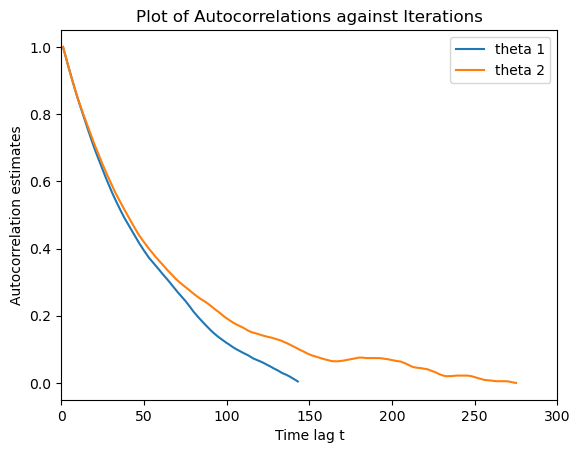

In [112]:
plt.plot(iterations_1, autocorrelations[0:T[0], 0], label = 'theta 1')
plt.plot(iterations_2, autocorrelations[0:T[1], 1], label = 'theta 2')
plt.title('Plot of Autocorrelations against Iterations')
plt.xlabel('Time lag t')
plt.ylabel('Autocorrelation estimates')
plt.xlim(0,300)
plt.legend()